**Carregamento e Preparação dos Dados**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import re
import shutil

In [ ]:
# --- CONFIGURAÇÃO ---
dataset_dir = os.path.join('data', 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
SEED = 42

# Remove a pasta 'unsup' para evitar problemas!
unsup_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(unsup_dir):
    shutil.rmtree(unsup_dir)
    print(f" Pasta intrusa removida: {unsup_dir}")
else:
    print(" A pasta 'unsup' não existe mais. Tudo limpo.")

# --- 1. CARREGAR TREINO ---
print("\nCarregando dados de TREINO...")
train_dataset = utils.text_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED
)

# --- 2. CARREGAR VALIDAÇÃO ---
print("Carregando dados de VALIDAÇÃO...")
validation_dataset = utils.text_dataset_from_directory(
    train_dir,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED
)

# --- 3. CARREGAR TESTE ---
print("Carregando dados de TESTE...")
test_dataset = utils.text_dataset_from_directory(
    test_dir,
    batch_size=BATCH_SIZE
)

# --- VERIFICAÇÃO FINAL ---
print("\n Classes finais:", train_dataset.class_names)
# deve aparecer apenas: ['neg', 'pos']

✨ A pasta 'unsup' não existe mais. Tudo limpo.

Carregando dados de TREINO...
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Carregando dados de VALIDAÇÃO...
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Carregando dados de TESTE...
Found 25000 files belonging to 2 classes.

✅ Classes finais: ['neg', 'pos']


In [16]:
# Salvando o nome das classes
class_names = train_dataset.class_names
print(f"Nomes das classes: {class_names}") # Deve imprimir ['neg', 'pos']

# Aplicando otimizaão
# A partir daqui, train_dataset muda de tipo e fica mais rápido
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Pipeline de dados otimizado com sucesso!")

Nomes das classes: ['neg', 'pos']
Pipeline de dados otimizado com sucesso!


**Pré-processamento do Texto**

O coração do pré-processamento será a camada TextVectorization. Ela executa três tarefas essenciais:

1- Padronização: Limpa o texto (remove pontuação, converte para minúsculas, etc.).

2- Tokenização: Divide o texto em palavras individuais (tokens).

3- Vetorização: Converte cada token em um número inteiro.

Esta camada será treinada com nossos dados e depois integrada diretamente ao modelo, garantindo que o pré-processamento seja consistente durante o treino, avaliação e inferência.

In [29]:
# 1. Definir parâmetros para a vetorização
VOCAB_SIZE = 10000  # Manter as 10.000 palavras mais frequentes
SEQUENCE_LENGTH = 250 # Padronizar todas as críticas para terem 250 palavras

# 2. Criar a camada de vetorização de texto
# A camada já lida com a conversão para minúsculas e remoção de pontuação por padrão
vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

# 3. Treinar a camada de vetorização nos dados de treino
# É crucial usar apenas os dados de treino para construir o vocabulário,
# evitando vazamento de dados (data leakage) do conjunto de teste.
# Mapeamos o dataset para extrair apenas o texto, descartando os rótulos.
train_text = train_dataset.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

# --- Verificação do Processo ---
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Exemplo de como um lote de texto é convertido em números
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("--- Exemplo de Vetorização ---")
print("Crítica Original:", first_review.numpy().decode('utf-8'))
# Usar a variável 'class_names' (salva antes de aplicar cache/prefetch) em vez de acessar attribute no dataset
print("Rótulo:", class_names[int(first_label.numpy())])
print("\nCrítica Vetorizada:", vectorize_layer(tf.constant([first_review.numpy()])).numpy()[0, :15])
print("Palavras correspondentes:", vectorize_layer.get_vocabulary()[12:20]) # Exemplo de vocabulário

--- Exemplo de Vetorização ---
Crítica Original: "Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn't all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that's all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)
Rótulo: neg

Crítica Vetorizada: [   1    7    4  194   18 2941   12  256  127   51  384   71  167  257
   70]
Palavras correspondentes: [np.str_('that'), np.str_('br'), np.str_('was'), np.str_('as')

**Construção do Modelo RNN (com LSTM)**

Com o pré-processamento definido, podemos construir a arquitetura da nossa rede neural.

1- Camada de Embedding: Transforma os números inteiros (tokens) em vetores densos de tamanho fixo (embedding_dim). Isso permite que o modelo aprenda o significado e as relações entre as palavras.

2- Camada Bidirecional (LSTM): O núcleo da nossa RNN. A LSTM (Long Short-Term Memory) é uma variante de RNN eficaz para capturar dependências de longo prazo no texto. Usar Bidirectional permite que a rede processe a sequência de texto tanto da esquerda para a direita quanto da direita para a esquerda, capturando um contexto mais rico.

3- Camadas Densas: As camadas finais que atuam como um classificador sobre as features extraídas pela LSTM. A última camada usa a ativação sigmoid, pois a saída é binária (Positivo/Negativo).

In [30]:
# Dimensão do Embedding (representação vetorial de cada palavra)
EMBEDDING_DIM = 16

model = tf.keras.Sequential([
    # 1. Camada de Entrada
    layers.Input(shape=(1,), dtype=tf.string),

    # 2. Camada de Pré-processamento
    vectorize_layer,

    # 3. Camada de Embedding
    layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name="embedding_layer"),

    # 4. Camada RNN Bidirecional ÚNICA
    # Removemos a segunda LSTM para reduzir drasticamente a complexidade do modelo.
    # Esta camada agora agrega a sequência completa (sem return_sequences=True).
    layers.Bidirectional(layers.LSTM(32)),

    # 5. Camadas de classificação final
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.7), # Aumentamos o Dropout para FORÇAR o modelo a generalizar mais!
    layers.Dense(1, activation='sigmoid')
])

**Compilação e Treinamento do Modelo**

Iremos configurar o otimizador, a função de perda e as métricas para monitorar o treinamento.

*loss='binary_crossentropy': Ideal para problemas de classificação binária.

*optimizer='adam': Um otimizador robusto e amplamente utilizado.

*metrics=['accuracy']: Para monitorar a acurácia durante o treinamento.

In [31]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Visualizar a arquitetura do modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 250, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,657 (682.25 KB)

 Trainable params: 174,657 (682.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Treinamento: alimentamos o modelo com os dados de treino e validação.
print("Iniciando o treinamento com Early Stopping...")

# 1. Definir o Early Stopping
# patience=3: O treinamento para se a val_loss não diminuir por 3 épocas consecutivas.
# restore_best_weights=True: Restaura os pesos do modelo da época onde a val_loss foi a menor.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Definimos o EPOCHS para um número alto, confiando no callback para parar no ponto certo
EPOCHS = 100 

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    # A CORREÇÃO ESTÁ AQUI: Passando o callback para o Keras
    callbacks=[early_stopping_callback] 
)

print("Treinamento concluído.")

Iniciando o treinamento com Early Stopping...
Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 90ms/step - accuracy: 0.6970 - loss: 0.5747 - val_accuracy: 0.5730 - val_loss: 0.6708
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.6665 - loss: 0.6076 - val_accuracy: 0.7906 - val_loss: 0.5084
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/step - accuracy: 0.8435 - loss: 0.4082 - val_accuracy: 0.8412 - val_loss: 0.3933
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.8951 - loss: 0.2985 - val_accuracy: 0.8562 - val_loss: 0.3652
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 102ms/step - accuracy: 0.9176 - loss: 0.2490 - val_accuracy: 0.8592 - val_loss: 0.3809
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.9338 - loss: 0.2114 - val_accuracy: 0.8530 - val_loss: 0.3931
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.9409 - loss: 0.1947 - val_accuracy: 0.8410 - val_loss: 0.4078
Treinamento concluído.


**Passo 5: Avaliação do Desempenho do Modelo**

É crucial analisar o comportamento do modelo durante o treinamento e validar seu desempenho final em dados que ele nunca viu.

**Visualização das Curvas de Aprendizagem:**

**Acurácia:** Esperamos que a acurácia de treino e validação subam e se estabilizem.

**Perda (Loss):** Esperamos que a perda de treino e validação diminuam.

**Overfitting:** Se a perda de validação começar a aumentar enquanto a de treino continua a cair, é um sinal de que o modelo está superajustando (decorando os dados de treino).

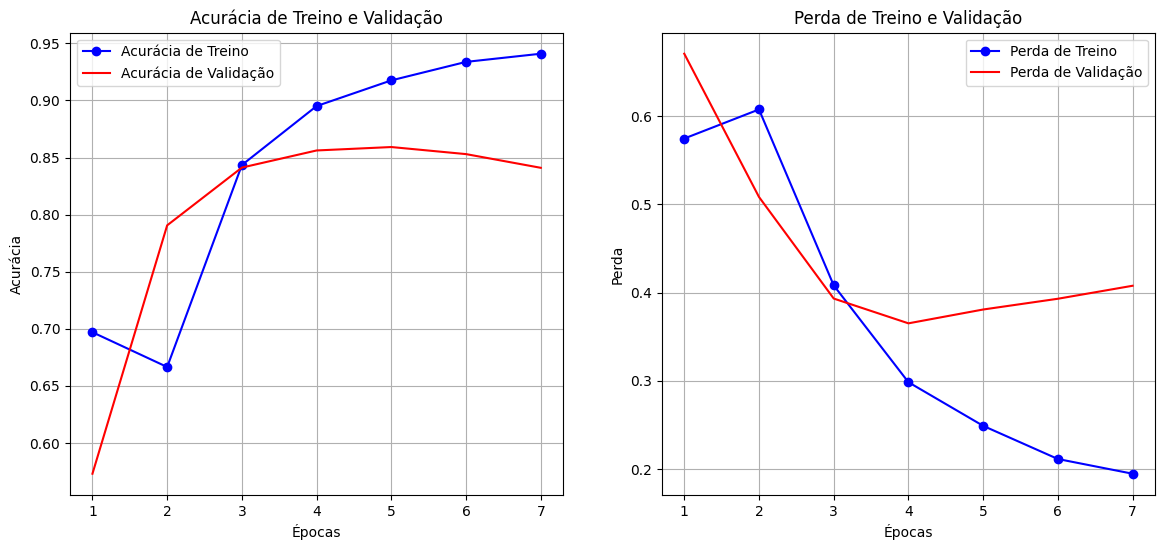

In [33]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Acurácia de Treino')
plt.plot(epochs, val_acc, 'r-', label='Acurácia de Validação')
plt.title('Acurácia de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend()

# Gráfico da Perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Perda de Treino')
plt.plot(epochs, val_loss, 'r-', label='Perda de Validação')
plt.title('Perda de Treino e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.grid(True)
plt.legend()

plt.show()

**Avaliação Final no Conjunto de Teste:**

In [34]:
# Esta é a métrica final que representa o quão bem o nosso modelo generaliza para novos dados.
loss, accuracy = model.evaluate(test_dataset)
print(f"\nAcurácia final no conjunto de teste: {accuracy * 100:.2f}%")
print(f"Perda final no conjunto de teste: {loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.8407 - loss: 0.3991

Acurácia final no conjunto de teste: 84.07%
Perda final no conjunto de teste: 0.3991


**Passo 6: Testando o Modelo com Novas Frases**

A grande vantagem de incluir a camada TextVectorization no modelo é que agora podemos fazer predições diretamente a partir de strings de texto, sem a necessidade de aplicar o pré-processamento manualmente.

In [43]:
import tensorflow as tf

# --- TESTE COM NOVAS FRASES ---
novas_criticas = [
    "This movie was absolutely fantastic, I really loved it and would recommend it to everyone!",
    "It was a complete waste of my time. The plot was predictable and the acting was subpar.",
    "The movie was okay, not great but not terrible either. A bit forgettable.",
    "I've never seen something so beautiful and touching. A true masterpiece of cinema.",
    "The special effects were good, but the story was incredibly boring."
]

# Converte a lista para um Tensor de String do TensorFlow
input_tensor = tf.constant(novas_criticas)

# Usar o modelo para prever
predictions = model.predict(input_tensor)

# Interpretar os resultados
print("\n--- Análise de Novas Críticas ---")
for i, pred in enumerate(predictions):
    score = float(pred[0])
    sentiment = "Positivo" if score > 0.5 else "Negativo"
    confidence = score if sentiment == "Positivo" else 1 - score

    print(f"Crítica: \"{novas_criticas[i]}\"")
    print(f"Predição: {sentiment} (Confiança: {confidence:.2%})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step

--- Análise de Novas Críticas ---
Crítica: "This movie was absolutely fantastic, I really loved it and would recommend it to everyone!"
Predição: Positivo (Confiança: 92.27%)

Crítica: "It was a complete waste of my time. The plot was predictable and the acting was subpar."
Predição: Negativo (Confiança: 98.73%)

Crítica: "The movie was okay, not great but not terrible either. A bit forgettable."
Predição: Negativo (Confiança: 93.93%)

Crítica: "I've never seen something so beautiful and touching. A true masterpiece of cinema."
Predição: Positivo (Confiança: 96.77%)

Crítica: "The special effects were good, but the story was incredibly boring."
Predição: Negativo (Confiança: 94.37%)

